# Multi-Layer Perceptron(MLP) for Multi-Classification Problems

## 1. Required Packages and Data Import

### 1.1 Import the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation

### 1.2 Read data

In [2]:
!git clone https://github.com/ShuXin79/MLP-classification

Cloning into 'MLP-classification'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 10 (delta 0), reused 3 (delta 0), pack-reused 7
Unpacking objects: 100% (10/10), 56.33 MiB | 8.93 MiB/s, done.


In [3]:
DATASET_PATH = 'MLP-classification/dataset'     #Relative path

X_train = np.load(DATASET_PATH + '/train_data.npy')
X_test = np.load(DATASET_PATH + '/test_data.npy')

y_train = np.load(DATASET_PATH + '/train_label.npy')
y_test = np.load(DATASET_PATH + '/test_label.npy')

print("The size of training set data, test set data, training set label, test set label:")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

The size of training set data, test set data, training set label, test set label:
(50000, 128)
(50000, 1)
(10000, 128)
(10000, 1)


In [4]:
from sklearn.preprocessing import OneHotEncoder

# Use one-hot to process labels for training
encoder = OneHotEncoder(sparse_output=False)


y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.fit_transform(y_test.reshape(-1, 1))

## 2.Function Definition

### 2.1 Activation function

ReLU(x) = max(x,0)

In [5]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

### 2.2 Softmax and cross-entropy function

softmax(x_i) = e^x_i / sum(e^x_j) for all j

Cross entropy loss = -Σ(y_true * log(y_pred) + (1-y_true) * log(1-y_pred))

In [6]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_sample = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred)) / n_sample

### 2.3 Dropout function

In [7]:
def dropout_forward(all_neu, dropout_rate):
    dropout_neu = (np.random.rand(*all_neu.shape) >= dropout_rate) / (1 - dropout_rate)
    keep_neu = all_neu * dropout_neu
    return keep_neu, dropout_neu

def dropout_backward(bac_keep, dropout_neu):
    bac_neu = bac_keep * dropout_neu
    return bac_neu

### 2.4 Mini-batch splitting function

In [8]:
def mini_batch_split(X, y, batch_size):
    batch = np.arange(X.shape[0])
    np.random.shuffle(batch)
    X_shuffled = X[batch]
    y_shuffled = y[batch]
    mini_batches = [(X_shuffled[i:i + batch_size], y_shuffled[i:i + batch_size]) for i in range(0, X.shape[0], batch_size)]
    return mini_batches

## 3. MLP Implementation

### 3.1 **Three** HiddenLayers definition and initialization

In [34]:
# Define the neural structure
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 128
hidden_size3 = 64
output_size = y_train.shape[1]


# Initialize the weights and biases
# Wi, bi: The weights matrix and bias

W1 = np.random.randn(input_size, hidden_size1) / np.sqrt(input_size)
b1 = np.zeros((1, hidden_size1))
W2 = np.random.randn(hidden_size1, hidden_size2) / np.sqrt(hidden_size1)
b2 = np.zeros((1, hidden_size2))
W3 = np.random.randn(hidden_size2, hidden_size3) / np.sqrt(hidden_size2)
b3 = np.zeros((1, hidden_size3))
W4 = np.random.randn(hidden_size3, output_size) / np.sqrt(hidden_size3)
b4 = np.zeros((1, output_size))



### 3.2 Momentum-weights&biases initialization

In [35]:
# Initialize velocity for momentum
Mom_W1 = np.zeros(W1.shape)
Mom_b1 = np.zeros(b1.shape)
Mom_W2 = np.zeros(W2.shape)
Mom_b2 = np.zeros(b2.shape)
Mom_W3 = np.zeros(W3.shape)
Mom_b3 = np.zeros(b3.shape)
Mom_W4 = np.zeros(W4.shape)
Mom_b4 = np.zeros(b4.shape)

### 3.3 Training: forward propagation and backward propagation

In [36]:
import time

# Define the parameters, which can be changed easily for model improvement
epochs = 200
learning_rate = 0.005
momentum = 0.9
weight_decay = 0.00001
batch_size = 256
dropout_rate = 0.3

start_time = time.time()
total_loss = []

# Training loop
for epoch in range(epochs):
  mini_batches = mini_batch_split(X_train, y_train, batch_size)

  for X_batch, y_batch in mini_batches:

    # Forward propagation
    # Zi, Ai: The initial output value of the layer and the activated value

    Z1 = np.dot(X_batch, W1) + b1
    A1 = relu(Z1)
    #I only added the dropout method to the first hidden layer.
    A1, dropout_mask1 = dropout_forward(A1, dropout_rate) 
    Z2 = np.dot(A1, W2) + b2
    A2 = relu(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = relu(Z3)
    Z4 = np.dot(A3, W4) + b4
    A4 = softmax(Z4)

    # Compute loss with weight decay
    loss = cross_entropy_loss(y_batch, A4) + weight_decay * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) + np.sum(np.square(W4)))

    # Backward propagation
    # dZi, dWi, dbi: Output values from backward propagation and updated weights/biases

    dZ4 = A4 - y_batch
    dW4 = np.dot(A3.T, dZ4) / X_batch.shape[0]
    db4 = np.sum(dZ4, axis=0, keepdims=True) / X_batch.shape[0]
    dA3 = np.dot(dZ4, W4.T)
    dZ3 = dA3 * relu_derivative(Z3)
    dW3 = np.dot(A2.T, dZ3) / X_batch.shape[0]
    db3 = np.sum(dZ3, axis=0, keepdims=True) / X_batch.shape[0]
    dA2 = np.dot(dZ3, W3.T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / X_batch.shape[0]
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X_batch.shape[0]
    dA1 = np.dot(dZ2, W2.T)
    dA1 = dropout_backward(dA1, dropout_mask1)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X_batch.T, dZ1) + weight_decay * W1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X_batch.shape[0]

    # Update gradients with weight decay
    dW1 += weight_decay * W1
    dW2 += weight_decay * W2
    dW3 += weight_decay * W3
    dW4 += weight_decay * W4

    # Update weights and biases with momentum
    Mom_W4 = momentum * Mom_W4 + learning_rate * dW4
    W4 -= Mom_W4
    Mom_b4 = momentum * Mom_b4 + learning_rate * db4
    b4 -= Mom_b4

    Mom_W3 = momentum * Mom_W3 + learning_rate * dW3
    W3 -= Mom_W3
    Mom_b3 = momentum * Mom_b3 + learning_rate * db3
    b3 -= Mom_b3

    Mom_W2 = momentum * Mom_W2 + learning_rate * dW2
    W2 -= Mom_W2
    Mom_b2 = momentum * Mom_b2 + learning_rate * db2
    b2 -= Mom_b2

    Mom_W1 = momentum * Mom_W1 + learning_rate * dW1
    W1 -= Mom_W1
    Mom_b1 = momentum * Mom_b1 + learning_rate * db1
    b1 -= Mom_b1


  total_loss.append(loss)
  # Print loss every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss:.4f}")

end_time = time.time()

Epoch 0, Loss: 1.7193
Epoch 10, Loss: 1.4858
Epoch 20, Loss: 1.5811
Epoch 30, Loss: 1.5181
Epoch 40, Loss: 1.5629
Epoch 50, Loss: 1.4791
Epoch 60, Loss: 1.4340
Epoch 70, Loss: 1.3362
Epoch 80, Loss: 1.4063
Epoch 90, Loss: 1.4650
Epoch 100, Loss: 1.6067
Epoch 110, Loss: 1.7045
Epoch 120, Loss: 1.5419
Epoch 130, Loss: 1.3426
Epoch 140, Loss: 1.6660
Epoch 150, Loss: 1.6691
Epoch 160, Loss: 1.4996
Epoch 170, Loss: 1.5642
Epoch 180, Loss: 1.6977
Epoch 190, Loss: 1.5559


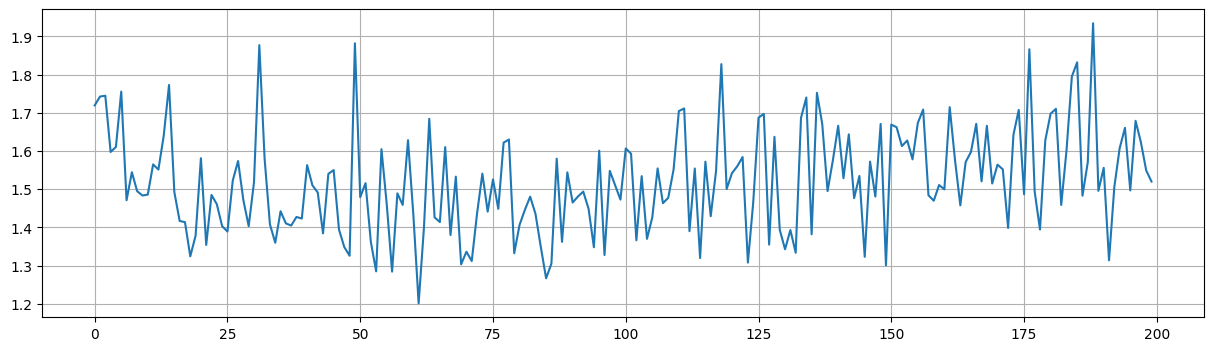

In [37]:
# Plot loss in epochs
pl.figure(figsize=(15,4))
pl.plot(total_loss)
pl.grid()

## 4. Test and Evaluation

In [38]:
from sklearn.metrics import accuracy_score       
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# The test is actually to perform the forward propagation process again
Z1_test = np.dot(X_test, W1) + b1
A1_test = relu(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2
A2_test = relu(Z2_test)
Z3_test = np.dot(A2_test, W3) + b3
A3_test = relu(Z3_test)
Z4_test = np.dot(A3_test, W4) + b4
A4_test = softmax(Z4_test)

# Make prediction
y_pred = np.argmax(A4_test, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the accuracy, precision and recall
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print('Time cost:', round(end_time-start_time,2), 'seconds')
print(y_pred)
print(y_true)

Accuracy: 54.53%
Precision: 55.29%
Recall: 54.53%
Time cost: 265.73 seconds
[3 9 8 ... 5 6 2]
[3 8 8 ... 5 1 7]


## 5. Comparison and Improvement

###5.1 ONLY USED FOR COMPARISON: MLP classifier based on sklearn framework.

In [15]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# I used sklearn to build the most basic MLP classifier, hoping to compare 
# it with my own MLP implemented above. Note: The classifiers in this part 
# are only used to compare the MLP I implemented manually, please do not 
# impose score penalties for this!

start_time1 = time.time()

X_train1 = np.load(DATASET_PATH + '/train_data.npy')
X_test1 = np.load(DATASET_PATH + '/test_data.npy')

y_train1 = np.load(DATASET_PATH + '/train_label.npy')
y_test1 = np.load(DATASET_PATH + '/test_label.npy')
y_train1 = y_train1.reshape(50000,)
y_test1 = y_test1.reshape(10000,)


mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=500)

mlp_classifier.fit(X_train1, y_train1)

y_pred1 = mlp_classifier.predict(X_test1)

accuracy1 = accuracy_score(y_test1, y_pred)
print(f'Accuracy: {accuracy1 * 100:.2f}%')

end_time1 = time.time()
print('Time cost:', round(end_time1-start_time1,2), 'seconds')

Accuracy: 54.31%
Time cost: 317.85 seconds


###5.2 Performance improvement attempt: use GELU activation function instead of ReLU

In [17]:
from scipy.special import erf

# Initialization, the same as privious code
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = y_train.shape[1]

W1 = np.random.randn(input_size, hidden_size1) / np.sqrt(input_size)
b1 = np.zeros((1, hidden_size1))
W2 = np.random.randn(hidden_size1, hidden_size2) / np.sqrt(hidden_size1)
b2 = np.zeros((1, hidden_size2))
W3 = np.random.randn(hidden_size2, hidden_size3) / np.sqrt(hidden_size2)
b3 = np.zeros((1, hidden_size3))
W4 = np.random.randn(hidden_size3, output_size) / np.sqrt(hidden_size3)
b4 = np.zeros((1, output_size))

Mom_W1 = np.zeros(W1.shape)
Mom_b1 = np.zeros(b1.shape)
Mom_W2 = np.zeros(W2.shape)
Mom_b2 = np.zeros(b2.shape)
Mom_W3 = np.zeros(W3.shape)
Mom_b3 = np.zeros(b3.shape)
Mom_W4 = np.zeros(W4.shape)
Mom_b4 = np.zeros(b4.shape)

# Define the GELU function
def gelu(x):
    return 0.5 * x * (1 + erf(x / np.sqrt(2)))

def gelu_derivative(x):
    c = np.sqrt(2 / np.pi)
    return 0.5 * (1 + erf(x / np.sqrt(2))) + c * x * np.exp(-x**2 / 2)

# The same code as before, but changed ReLU activition function to GELU 

#From the above experiments it can be seen that the model converges very quickly, so here I reduced the epochs to 50
epochs = 50   

learning_rate = 0.005
momentum = 0.9
weight_decay = 0.00001
batch_size = 5000
dropout_rate = 0.5

start_time = time.time()
total_loss = []

for epoch in range(epochs):
  mini_batches = mini_batch_split(X_train, y_train, batch_size)

  for X_batch, y_batch in mini_batches:

    Z1 = np.dot(X_batch, W1) + b1
    A1 = gelu(Z1)

    A1, dropout_mask1 = dropout_forward(A1, dropout_rate) 
    Z2 = np.dot(A1, W2) + b2
    A2 = gelu(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = gelu(Z3)
    Z4 = np.dot(A3, W4) + b4
    A4 = softmax(Z4)

    loss = cross_entropy_loss(y_batch, A4) + weight_decay * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) + np.sum(np.square(W4)))

    dZ4 = A4 - y_batch
    dW4 = np.dot(A3.T, dZ4) / X_batch.shape[0]
    db4 = np.sum(dZ4, axis=0, keepdims=True) / X_batch.shape[0]
    dA3 = np.dot(dZ4, W4.T)
    dZ3 = dA3 * gelu_derivative(Z3)
    dW3 = np.dot(A2.T, dZ3) / X_batch.shape[0]
    db3 = np.sum(dZ3, axis=0, keepdims=True) / X_batch.shape[0]
    dA2 = np.dot(dZ3, W3.T)
    dZ2 = dA2 * gelu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / X_batch.shape[0]
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X_batch.shape[0]
    dA1 = np.dot(dZ2, W2.T)
    dA1 = dropout_backward(dA1, dropout_mask1)
    dZ1 = dA1 * gelu_derivative(Z1)
    dW1 = np.dot(X_batch.T, dZ1) + weight_decay * W1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X_batch.shape[0]

    # Update gradients with weight decay
    dW1 += weight_decay * W1
    dW2 += weight_decay * W2
    dW3 += weight_decay * W3
    dW4 += weight_decay * W4

    # Update weights and biases with momentum
    Mom_W4 = momentum * Mom_W4 + learning_rate * dW4
    W4 -= Mom_W4
    Mom_b4 = momentum * Mom_b4 + learning_rate * db4
    b4 -= Mom_b4

    Mom_W3 = momentum * Mom_W3 + learning_rate * dW3
    W3 -= Mom_W3
    Mom_b3 = momentum * Mom_b3 + learning_rate * db3
    b3 -= Mom_b3

    Mom_W2 = momentum * Mom_W2 + learning_rate * dW2
    W2 -= Mom_W2
    Mom_b2 = momentum * Mom_b2 + learning_rate * db2
    b2 -= Mom_b2

    Mom_W1 = momentum * Mom_W1 + learning_rate * dW1
    W1 -= Mom_W1
    Mom_b1 = momentum * Mom_b1 + learning_rate * db1
    b1 -= Mom_b1


  total_loss.append(loss)
  # Print loss every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss:.4f}")

end_time = time.time()


Epoch 0, Loss: 3.5930
Epoch 10, Loss: 1.9606
Epoch 20, Loss: 1.8405
Epoch 30, Loss: 1.7437
Epoch 40, Loss: 1.7150


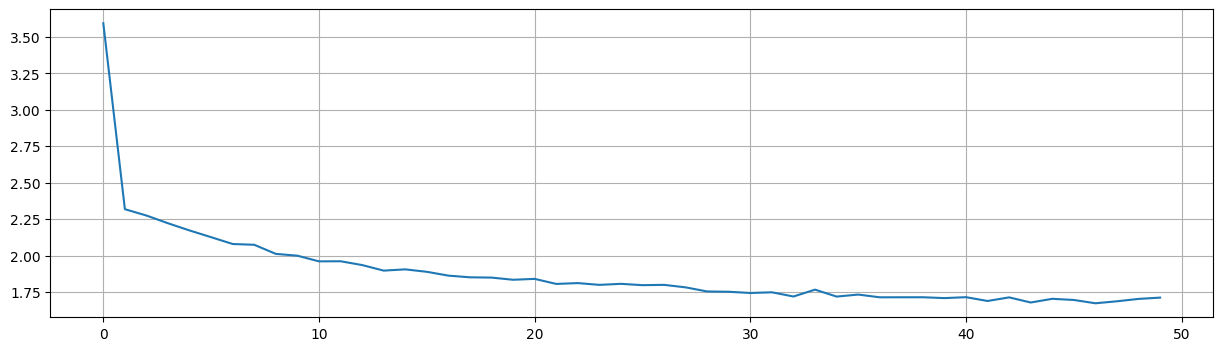

In [18]:
pl.figure(figsize=(15,4))
pl.plot(total_loss)
pl.grid()

In [20]:
# The test is actually to perform the forward propagation process again
Z1_test = np.dot(X_test, W1) + b1
A1_test = relu(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2
A2_test = relu(Z2_test)
Z3_test = np.dot(A2_test, W3) + b3
A3_test = relu(Z3_test)
Z4_test = np.dot(A3_test, W4) + b4
A4_test = softmax(Z4_test)

# Make prediction
y_pred = np.argmax(A4_test, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the accuracy, precision and recall
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print('Time cost:', round(end_time-start_time,2), 'seconds')
print(y_pred)
print(y_true)

Accuracy: 48.47%
Precision: 47.80%
Recall: 48.47%
Time cost: 278.25 seconds
[0 8 8 ... 5 4 7]
[3 8 8 ... 5 1 7]


In [21]:
# The test is actually to perform the forward propagation process again
a = X_train[30000:40000]
b = y_train[30000:40000]
Z1_test = np.dot(a, W1) + b1
A1_test = relu(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2
A2_test = relu(Z2_test)
Z3_test = np.dot(A2_test, W3) + b3
A3_test = relu(Z3_test)
Z4_test = np.dot(A3_test, W4) + b4
A4_test = softmax(Z4_test)

# Make prediction
y_pred = np.argmax(A4_test, axis=1)
y_true = np.argmax(b, axis=1)

# Calculate the accuracy, precision and recall
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print('Time cost:', round(end_time-start_time,2), 'seconds')
print(y_pred)
print(y_true)

Accuracy: 50.09%
Precision: 49.22%
Recall: 50.09%
Time cost: 278.25 seconds
[8 6 0 ... 6 0 8]
[0 6 0 ... 6 2 8]


## Summary